In [103]:
from IPython.display import display, Math, Latex
import time
import requests
import pandas as pd
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


In [20]:
curr_date = round(time.time())
start_date = curr_date*1000 - 7*24*60*60*1000
sym_request = requests.get('https://api.bitfinex.com/v1/symbols')


In [44]:
if sym_request.status_code == 200:
    symbols = eval(sym_request.content)

symbols_filtered =[]
for elem in symbols:
    if elem[3:] == 'btc':
        symbols_filtered.append(elem)
print(symbols_filtered)

['ltcbtc', 'ethbtc', 'etcbtc', 'rrtbtc', 'zecbtc', 'xmrbtc', 'dshbtc', 'xrpbtc', 'iotbtc', 'eosbtc', 'sanbtc', 'omgbtc', 'neobtc', 'etpbtc', 'qtmbtc', 'avtbtc', 'edobtc', 'btgbtc', 'datbtc', 'qshbtc', 'yywbtc', 'gntbtc', 'sntbtc', 'batbtc', 'mnabtc', 'funbtc', 'zrxbtc', 'tnbbtc', 'spkbtc', 'trxbtc', 'rcnbtc', 'rlcbtc', 'aidbtc', 'sngbtc', 'repbtc', 'elfbtc', 'iosbtc', 'aiobtc', 'reqbtc', 'rdnbtc', 'lrcbtc', 'waxbtc', 'daibtc', 'cfibtc', 'agibtc', 'bftbtc', 'mtnbtc', 'odebtc', 'antbtc', 'dthbtc', 'mitbtc', 'stjbtc', 'xlmbtc', 'xvgbtc', 'bcibtc', 'mkrbtc', 'kncbtc', 'poabtc', 'lymbtc', 'utkbtc', 'veebtc', 'dadbtc', 'orsbtc', 'aucbtc', 'poybtc', 'fsnbtc', 'cbtbtc', 'zcnbtc', 'senbtc', 'ncabtc', 'cndbtc', 'ctxbtc', 'paibtc', 'seebtc', 'essbtc', 'atmbtc', 'hotbtc', 'dtabtc', 'iqxbtc', 'wprbtc', 'zilbtc', 'bntbtc', 'vetbtc', 'xtzbtc', 'omnbtc', 'dgbbtc', 'bsvbtc', 'babbtc', 'rbtbtc']


In [46]:
final_df = pd.DataFrame()
for pair in symbols_filtered:
    time.sleep(3)
    r = requests.get('https://api.bitfinex.com/v2/candles/trade:30m:t'+pair.upper()+'/hist?sort=1&start='+str(start_date)+'&limit=1000')
    if r.status_code == 200:
        res = eval(r.content)
        if len(res) > 660:
            df = pd.DataFrame(res)
            df.set_index(0)
            final_df[pair] = df[2]

final_df.dropna(inplace=True)
final_df.to_csv('bitfinex_df.csv')

       ltcbtc    ethbtc    etcbtc    zecbtc    xmrbtc    dshbtc    xrpbtc  \
0    0.008156  0.028284  0.001160  0.019355  0.014848  0.022884  0.000091   
1    0.008114  0.028260  0.001158  0.019269  0.014902  0.022882  0.000091   
2    0.008165  0.028376  0.001157  0.019331  0.014830  0.022908  0.000091   
3    0.008155  0.028315  0.001161  0.019429  0.014864  0.022882  0.000091   
4    0.008142  0.028265  0.001161  0.019408  0.014852  0.022894  0.000091   
5    0.008186  0.028589  0.001161  0.019445  0.014876  0.022768  0.000091   
6    0.008220  0.028420  0.001168  0.019338  0.014825  0.022739  0.000091   
7    0.008079  0.028101  0.001162  0.019122  0.014769  0.022754  0.000090   
8    0.008079  0.027956  0.001151  0.019028  0.014730  0.022704  0.000090   
9    0.008072  0.027819  0.001148  0.018861  0.014569  0.022704  0.000090   
10   0.008059  0.027780  0.001152  0.018921  0.014544  0.022533  0.000089   
11   0.008044  0.027955  0.001144  0.018949  0.014679  0.022611  0.000089   

In [101]:
final_df = pd.read_csv('bitfinex_df.csv',index_col=0)
final_df.tail()

,ltcbtc,ethbtc,etcbtc,zecbtc,xmrbtc,xrpbtc,eosbtc,neobtc,dadbtc
656,0.007140,0.026153,0.001107,0.015746,0.012670,0.000088,0.000576,0.001720,0.000011
657,0.007141,0.026141,0.001118,0.015744,0.012668,0.000089,0.000575,0.001731,0.000011
658,0.007097,0.025936,0.001122,0.015768,0.012600,0.000088,0.000569,0.001728,0.000011
659,0.007025,0.025968,0.001120,0.015800,0.012644,0.000088,0.000572,0.001728,0.000011
660,0.007031,0.025975,0.001121,0.015791,0.012591,0.000088,0.000571,0.001728,0.000011


## Split Data into Train and Test sets

In [306]:
train_df = final_df[:330]#trains a bad name, more like test for cointegration set
backtest_df = final_df[330:]
backtest_df.tail()

,ltcbtc,ethbtc,etcbtc,zecbtc,xmrbtc,xrpbtc,eosbtc,neobtc,dadbtc
656,0.007140,0.026153,0.001107,0.015746,0.012670,0.000088,0.000576,0.001720,0.000011
657,0.007141,0.026141,0.001118,0.015744,0.012668,0.000089,0.000575,0.001731,0.000011
658,0.007097,0.025936,0.001122,0.015768,0.012600,0.000088,0.000569,0.001728,0.000011
659,0.007025,0.025968,0.001120,0.015800,0.012644,0.000088,0.000572,0.001728,0.000011
660,0.007031,0.025975,0.001121,0.015791,0.012591,0.000088,0.000571,0.001728,0.000011


## Engle–Granger two-step method


In [307]:
def find_cointegrated_pairs(df, critial_level = 0.05):
    n = df.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = df.keys() # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            pair1 = df[keys[i]] # obtain the price of two contract
            pair2 = df[keys[j]]
            result = sm.tsa.stattools.coint(pair1, pair2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                x = np.array(df.iloc[:,i], dtype=np.float32)
                y = np.array(df.iloc[:,j], dtype=np.float32)
                diff = np.abs(x-y)
                mean = np.mean(diff)
                std = np.std(diff, ddof=1)
                pairs.append((keys[i], keys[j], pvalue,mean,std)) # record the contract with that p-value
    labels = ['pair1','pair2','pvalue','mean','std']
    new_df = pd.DataFrame(pairs,columns=labels)
    sorted_df = new_df.sort_values(by=['mean', 'std'],ascending=[False,True] )#highest mean lowest std-> find out why higheest mean
    return sorted_df

sorted_df = find_cointegrated_pairs(train_df)
sorted_df = sorted_df.reset_index(drop=True)

sorted_df.head(10)

,pair1,pair2,pvalue,mean,std
0,ethbtc,eosbtc,0.046535,0.027274,2.532868e-04
1,ethbtc,etcbtc,0.033925,0.026787,2.578054e-04
2,xmrbtc,dadbtc,0.033947,0.014281,2.033507e-04
3,xmrbtc,eosbtc,0.034151,0.013615,1.788418e-04
4,xmrbtc,neobtc,0.009379,0.012367,1.855747e-04
5,neobtc,dadbtc,0.011344,0.001913,3.260870e-05
6,xrpbtc,neobtc,0.004175,0.001835,3.306279e-05
7,xrpbtc,eosbtc,0.018744,0.000587,4.399424e-05
8,xrpbtc,dadbtc,0.013145,0.000079,8.923978e-07


## Settings for Pairs, Entry and Exit

In [340]:
pair_num = 0
zLimEntry = 2
zLimExit = 0.1

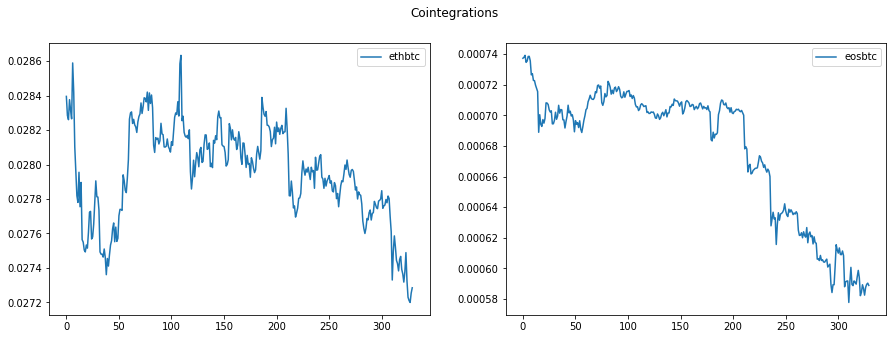

In [341]:
f, (p1, p2) = plt.subplots(1, 2, sharey=False,figsize=(15,5))
f.suptitle('Cointegrations')
p1.plot(range(len(train_df[sorted_df.loc[pair_num,'pair1']])),train_df[sorted_df.loc[pair_num,'pair1']], label = sorted_df.loc[pair_num,'pair1'])
p2.plot(range(len(train_df[sorted_df.loc[pair_num,'pair2']])),train_df[sorted_df.loc[pair_num,'pair2']], label = sorted_df.loc[pair_num,'pair2'])
p1.legend(loc='upper right')
p2.legend(loc='upper right')
plt.show()

# Kalman Filter
According to Wikipedia, Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each time-frame. The filter is named after Rudolf E. Kálmán, one of the primary developers of its theory.

Because the Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones, a particularly useful application is an estimation of rolling parameters of the data. When using a Kalman filter, there’s no window length that we need to specify. This is useful for computing the moving average if that’s what we are interested in, or for smoothing out estimates of other quantities. Thanks to Quantopian, they already provide the source code for calculating the moving average and Regression with Kalman Filter.

In [342]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
  from pykalman import KalmanFilter
  kf = KalmanFilter(transition_matrices = [1],
     observation_matrices = [1],
     initial_state_mean = 0,
     initial_state_covariance = 1,
     observation_covariance=1,
     transition_covariance=.01)

  # Use the observed values of the price to get a rolling mean
  state_means, _ = kf.filter(x.values)
  state_means = pd.Series(state_means.flatten(), index=x.index)
  return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
  delta = 1e-3
  trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
  obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

  kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
     initial_state_mean=[0,0],
     initial_state_covariance=np.ones((2, 2)),
     transition_matrices=np.eye(2),
     observation_matrices=obs_mat,
     observation_covariance=2,
     transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
  state_means, state_covs = kf.filter(y.values)
  return state_means



## Hurst exponent and Half-life
The Hurst exponent is used as a measure of long-term memory of time series. It relates to the auto-correlations of the time series and the rate at which these decrease as the lag between pairs of values increases. Studies involving the Hurst exponent were originally developed in hydrology for the practical matter of determining optimum dam sizing for the Nile river’s volatile rain and drought conditions that had been observed over a long period of time. The name “Hurst exponent”, or “Hurst coefficient”, derives from Harold Edwin Hurst (1880–1978), who was the lead researcher in these studies; the use of the standard notation H for the coefficient relates to his name also.

To simplify things, the important info to remember here is that a time series can be characterized in the following manner with regard to the Hurst exponent (H):

H < 0.5 – The time series is mean reverting
H = 0.5 – The time series is a Geometric Brownian Motion
H > 0.5 – The time series is trending
However just because a time series displays mean-reverting properties, it doesn’t necessarily mean that we can trade it profitably – there’s a difference between a series that deviates and mean reverts every week and one that takes 10 years to mean revert. I’m not sure too many traders would be willing to sit and wait around for 10 years to close out a trade profitably.
To get an idea of how long each mean reversion is going to take, we can look into the “half-life” of the time series

In [343]:
def half_life(spread):
  spread_lag = spread.shift(1)
  spread_lag.iloc[0] = spread_lag.iloc[1]
  spread_ret = spread - spread_lag
  spread_ret.iloc[0] = spread_ret.iloc[1]
  spread_lag2 = sm.add_constant(spread_lag)
  model = sm.OLS(spread_ret,spread_lag2)
  res = model.fit()
  halflife = int(round(-np.log(2) / res.params[1],0))

  if halflife <= 0:
    halflife = 1
  return halflife

In [344]:
pairs = [sorted_df.loc[pair_num,'pair1'],sorted_df.loc[pair_num,'pair2']]
pair1 = pd.Series(list(backtest_df[pairs[0]]))
pair2 = pd.Series(list(backtest_df[pairs[1]]))
df1 = pd.DataFrame({'pair1':pair1,'pair2':pair2})
state_means = KalmanFilterRegression(KalmanFilterAverage(pair2),KalmanFilterAverage(pair1))
df1['hr'] = - state_means[:,0]
df1['spread'] = df1.pair1 + (df1.pair2 * df1.hr)

# calculate half life
halflife = half_life(df1['spread'])

# calculate z-score with window = half life period

meanSpread = df1.spread.rolling(window=halflife).mean()
stdSpread = df1.spread.rolling(window=halflife).std()
df1['zScore'] = (df1.spread-meanSpread)/stdSpread


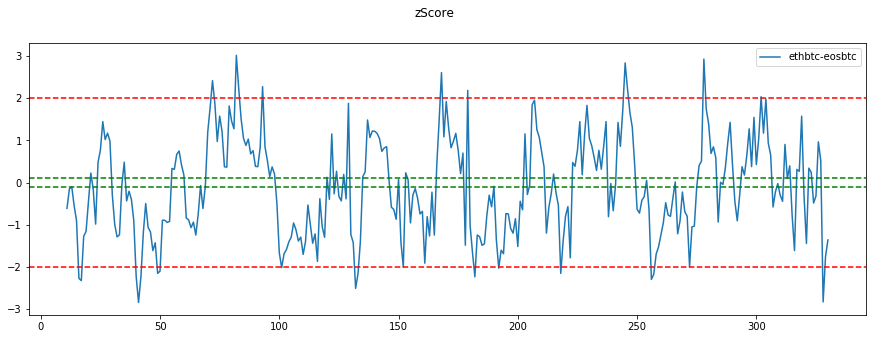

In [345]:
f, p1 = plt.subplots(1, 1, figsize=(15,5))
f.suptitle('zScore')
p1.plot(range(len(df1['zScore'])),df1['zScore'], label = str('-'.join([str(x) for x in pairs])))
plt.axhline(y=zLimEntry, color='r', linestyle='--')
plt.axhline(y=-zLimEntry, color='r', linestyle='--')
plt.axhline(y=zLimExit, color='g', linestyle='--')
plt.axhline(y=-zLimExit, color='g', linestyle='--')
plt.legend()
plt.show()

In [346]:
test_df = pd.DataFrame(df1['zScore'])
test_df[sorted_df.loc[pair_num,'pair1']] = pd.Series(pair1, index=df1.index)
test_df[sorted_df.loc[pair_num,'pair2']] = pd.Series(pair2, index=df1.index)

test_df.tail()

,zScore,ethbtc,eosbtc
326,0.967739,0.026153,0.000576
327,0.525359,0.026141,0.000575
328,-2.827285,0.025936,0.000569
329,-1.755590,0.025968,0.000572
330,-1.358012,0.025975,0.000571


In [347]:
entry = zLimEntry
exit  = zLimExit
starting_funds = 2 #btc
open_position = False
balance = 0
side = 'no side'
long_price = 0
short_price = 0
trade_count = 0
p1 = sorted_df.loc[pair_num,'pair1']
p2 = sorted_df.loc[pair_num,'pair2']
for i in range(len(test_df['zScore'])):
    if(open_position == False and abs(test_df['zScore'][i]) > entry):
        open_position = True
        if(test_df['zScore'][i]>0):
            trade_count += 1
            print('Short ETHBTC & Long NEOBTC @ Index', i)
            side = 'long'
            long_price= test_df.loc[i,p2] 
            long_funds = (starting_funds*0.5)/test_df.loc[i,p2]
            short_price= test_df.loc[i,p1] 
            short_funds = (starting_funds*0.5)/test_df.loc[i,p1]
            print('LONG Price:{} | Long Amount:{} | Base Amount:{}'.format(long_price,long_funds, starting_funds*0.5))
            print('SHORT Price:{} | Short Amount:{} | Base Amount:{}'.format(short_price,short_funds, starting_funds*0.5))
            print('--')
        else:
            print('Long ETHBTC & Short NEOBTC @ Index',i)
            side = 'short'
            long_price= test_df.loc[i,p1] 
            long_funds = (starting_funds*0.5)/test_df.loc[i,p1]
            short_price= test_df.loc[i,p2] 
            short_funds = (starting_funds*0.5)/test_df.loc[i,p2]
            print('LONG Price:{} | Quote Amount:{} | Base Amount:{}'.format(long_price,long_funds, starting_funds*0.5))
            print('SHORT Price:{} | Quote Amount:{} | Base Amount:{}'.format(short_price,short_funds, starting_funds*0.5))
            print('--')
    if(open_position == True and abs(test_df['zScore'][i]) < exit):
        open_position = False
        print('Positions closed @ Index',i)
        if(side == 'long'):
            close_long_price = test_df.loc[i,p2] 
            close_long_funds = long_funds * close_long_price
            close_short_price = test_df.loc[i,p1] 
            close_short_funds = short_funds * close_short_price
            trade_profits = (close_long_funds - (starting_funds*0.5)) + ((starting_funds*0.5) - close_short_funds)
            print('LONG Price:{} | CLOSE Amount:{} '.format(close_long_price,close_long_funds))
            print('SHORT Price:{} | CLOSE Amount:{} '.format(close_short_price, close_short_funds))
            print('Trade Profit: ', trade_profits)
            balance += trade_profits
        else:
            close_long_price = test_df.loc[i,p1] 
            close_long_funds = long_funds * close_long_price
            close_short_price = test_df.loc[i,p2] 
            close_short_funds = short_funds * close_short_price
            trade_profits = (close_long_funds - (starting_funds*0.5)) + ((starting_funds*0.5) - close_short_funds)
            print('LONG Price:{} | CLOSE Amount:{} '.format(close_long_price,close_long_funds))
            print('SHORT Price:{} | CLOSE Amount:{} '.format(close_short_price, close_short_funds))
            print('Trade Profit: ', trade_profits)
            balance += trade_profits
        print('~~~~~~~~~~~~~')


print('Closing Balance:',(balance+starting_funds))
print('Profit: {} | %: {}' .format(balance, (balance/(balance+starting_funds))*100))
print('Trades:', trade_count)


Long ETHBTC & Short NEOBTC @ Index 16
LONG Price:0.026414 | Quote Amount:37.858711289467706 | Base Amount:1.0
SHORT Price:0.0005708999999999999 | Quote Amount:1751.6202487300754 | Base Amount:1.0
--
Positions closed @ Index 34
LONG Price:0.026545999999999997 | CLOSE Amount:1.0049973498902096 
SHORT Price:0.00054721 | CLOSE Amount:0.9585041163075846 
Trade Profit:  0.046493233582625026
~~~~~~~~~~~~~
Long ETHBTC & Short NEOBTC @ Index 40
LONG Price:0.026269999999999998 | Quote Amount:38.06623524933384 | Base Amount:1.0
SHORT Price:0.00053468 | Quote Amount:1870.2775491882994 | Base Amount:1.0
--
Positions closed @ Index 67
LONG Price:0.025186 | CLOSE Amount:0.9587362009897222 
SHORT Price:0.00049847 | CLOSE Amount:0.9322772499438916 
Trade Profit:  0.026458951045830625
~~~~~~~~~~~~~
Short ETHBTC & Long NEOBTC @ Index 72
LONG Price:0.00050164 | Long Amount:1993.4614464556255 | Base Amount:1.0
SHORT Price:0.025574 | Short Amount:39.10221318526629 | Base Amount:1.0
--
Positions closed @ Ind

# To Do

```
0) Add stop losses and figure out best stop loss strategy
1) Figure out and incorporate fees(shorting interest rates)
2) Get 1min data from Kraken, Bitfinex, Bitmex, Okex, Poloniex -> save to db for real time data pool
3) Make into an app, or api, maybe micropayment service?
4) Add automated trading functionality, initially on bitfinex and then expand to other exchages
5) Possibly add trading alerts emails
6) Figure out what big time hedge funds are currently using for hedge ratio(beta coefficient)
7) Hit up blockvision guys and brainstorm how to make this dope
```

## Sources
```
http://qed.econ.queensu.ca/working_papers/papers/qed_wp_1227.pdf
https://www.quantinsti.com/blog/kalman-filter-techniques-statistical-arbitrage-china-futures-market-python
http://www.quantatrisk.com/2017/11/07/earning-money-cryptocurrency-statistical-arbitrage-python/
https://www.youtube.com/watch?v=RxIdLu18SsE (approx 6.20)
http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/
```